In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict, Counter
import os

sns.set_context("poster")

In [2]:
from communotron import *

# A demo of _Communotron_

I) Initialization

- The following function is used to randomly assign sex to _Achrostichus_ sp. dauer larvae at the start of the simulation:

In [3]:
def det_sex(strain):
    if strain == 'C':
        if np.random.random() < 0.5:
            return 'M'
        else:
            return 'F'
    else:
        return 'H'

- The experimental fecundity data is used:

In [4]:
fec_df = pd.read_csv('./exp_data/summ_fec.csv', index_col=0)
C_fec_raw = [12.53, 22.8, 24.39, 22.32, 25.78, 22.7, 20.87, 21.36, 17.75, 10.44, 10.04, 10.81, 12.82, np.mean([12.82, 4.78]), 4.78, np.mean([4.78, 2.22]),  2.22]
C_fec = [int(round(x)) for x in C_fec_raw]
A_fec = list(fec_df[(fec_df['Species']=='P. pacificus') & (fec_df['Strain'] == 'RSO011')]['mean'])
B_fec = list(fec_df[(fec_df['Species']=='P. mayeri') & (fec_df['Strain'] == 'RSO012')]['mean'])

- The parameters of the simulation are set:

In [5]:
pPred=0.005 # Predation parameter
mStep=10 # Number of steps taking during random walk by each motile stage
period=300 # The period of resource availability
Tlim=300 # Up to Tlim, resource constantly replenishes according to its period
Tsim=1000 # The duration of the simulation in hours


grid_size=101
source_center = (grid_size//2, grid_size//2)  # Center of the source
source_diameter = grid_size//5  # Diameter of the source
decline_rate = 0.3  # Rate of decline
comm = Community(grid_size, source_center, source_diameter, decline_rate, resource_cycle=period, pred_par_b=pPred, time_lim=Tlim)
mf_probs = {'A': 1.0, 'B': 0.0, 'C': 0.0}
dev_pars = {'A': {0: 48, 1:72, 4:72, 5:24}, 'B':{0: 48, 1:96, 4:96, 5:24}, 'C':{0: 48, 1:120, 4:24, 5:24}}
surv_prs = {2: 500, 4: 1000, 5: 1000}
fec_data = {'A': A_fec, 'B':B_fec, 'C':C_fec}
age_lim = {'A' : 120, 'B': 120, 'C': 408}

comm.add_features(mf_probs, dev_pars, surv_prs, fec_data, age_lim)
# Expected initial number of worms
nA = np.random.poisson(10)
nB = np.random.poisson(10)
nC = np.random.poisson(0)
strains = np.array(['A' for i in range(nA)] + ['B' for i in range(nB)] + ['C' for i in range(nC)])
age = np.zeros(len(strains)) 
dev_state = np.ones(len(strains)) * 4 
# dev states: 0 (Egg), 1 (Juvenile), 2 (Adult), 3 (Dead), 4 (Dauer), 5 (Arrested juvenile)
mf_state = np.array([np.random.binomial(1, mf_probs[x]) for x in strains])
sex = np.array([det_sex(x) for x in strains])
comm.set_max_steps(mStep)
comm.add_strains(strains, dev_state, mf_state, age, sex)

In [6]:
comm.simulate(time=Tsim)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]


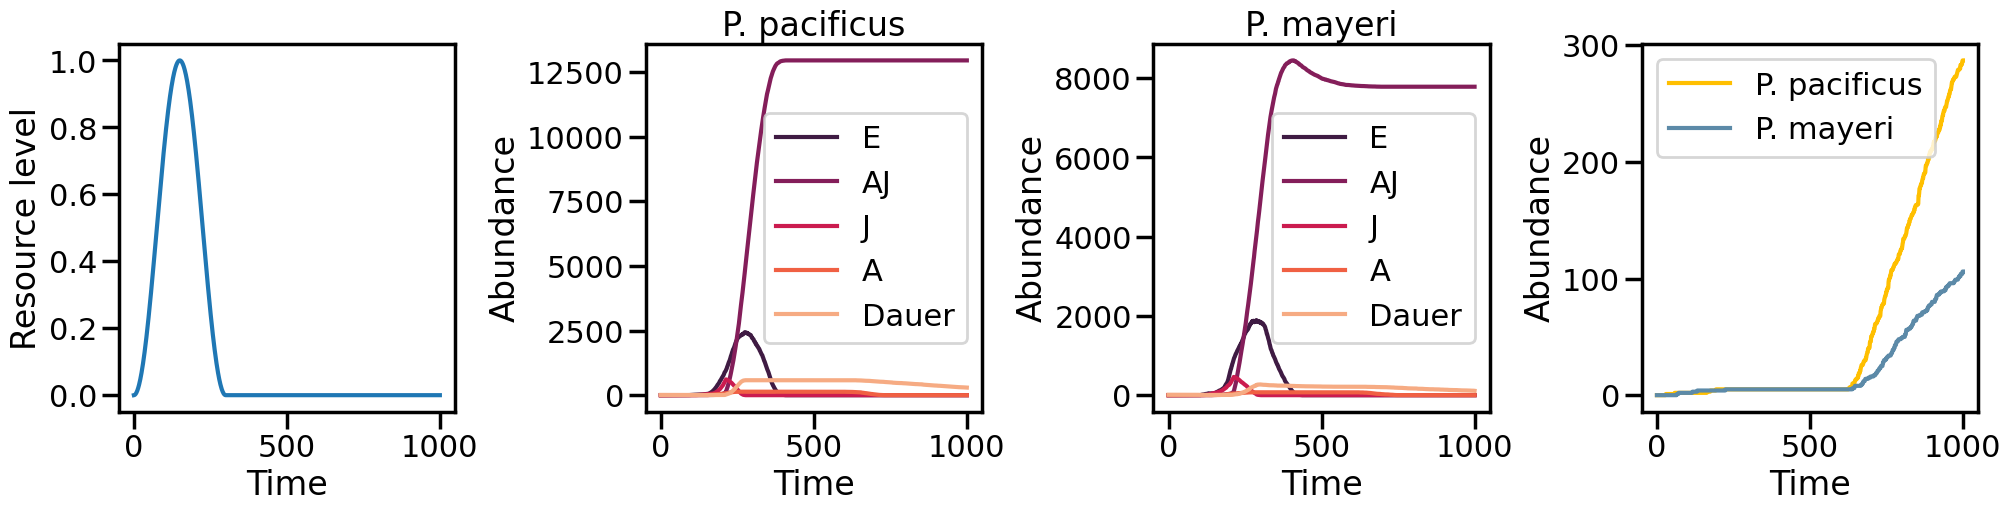

In [28]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=4,
    figsize=(20, 5),constrained_layout=True)

axes = axes.flatten()

axes[0].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"]['Resource'])

cols = sns.color_palette("rocket", n_colors=5)
for i,j in enumerate(['E', 'AJ', 'J', 'A', 'Dauer']):
    axes[1].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"][j], color=cols[i],label=j)
axes[1].legend()
for i,j in enumerate(['E', 'AJ', 'J', 'A', 'Dauer']):
    axes[2].plot(comm.history[comm.history["Strain"]=="B"]['Time'], comm.history[comm.history["Strain"]=="B"][j], color=cols[i],label=j)
axes[2].legend()

axes[3].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="A"]['cum_migrated'], color=(1.0, 0.75, 0.0),label='P. pacificus')
axes[3].plot(comm.history[comm.history["Strain"]=="A"]['Time'], comm.history[comm.history["Strain"]=="B"]['cum_migrated'], color=(0.36, 0.54, 0.66),label='P. mayeri')
axes[3].legend()

axes[0].set_ylabel('Resource level')

for ax in axes[1:]:
    ax.set_ylabel('Abundance')

for ax in axes:
    ax.set_xlabel('Time')

axes[1].set_title('P. pacificus')

axes[2].set_title('P. mayeri');